# Generative Adverserial Networks

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach: 

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. This rather simple approach can lead to some astounding results.

GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of handwritten digits similar to those from the MNIST database.

<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >

Here's what we're going to do:

* Define the problem statement
* Load the data (with transforms and normalization)
    * Denormalize for visual inspection of samples
* Define the Discriminator network
    * Study the activation function: Leaky ReLU
* Define the Generator network
    * Explain the output activation function: TanH
    * Look at some sample outputs
* Define losses, optimizers and helper functions for training
    * For discriminator
    * For generator
* Train the model
    * Save intermediate generated images to file
* Look at some outputs
* Save the models
* Commit to Jovian.ml

## 1. Load the Data

We begin by downloading and importing the data as a PyTorch dataset using the `MNIST` helper class from `torchvision.datasets`.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/Users/A117870943/opt/anaconda3/envs/anomaly_detection/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




<div class="alert alert-block alert-warning">
<b>Note:</b> We are are transforming the pixel values from the range `[0, 1]` to the range `[-1, 1]`. The reason for doing this will become clear when define the generator network. Let's look at a sample tensor from the data.
</div>

In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))



<div class="alert alert-block alert-info">
<b>Tip:</b> As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.
</div>

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


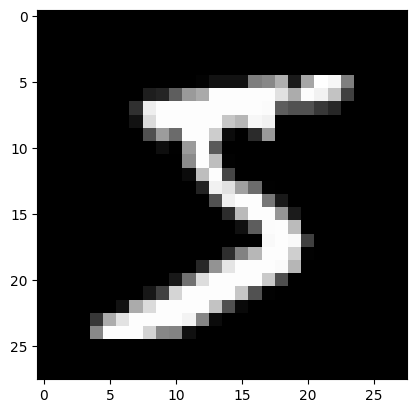

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Finally, let's create a dataloader to load the images in batches.

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 1, 1, 5, 1, 5, 0, 2, 8, 9, 0, 4, 1, 6, 8, 3, 3, 3, 3, 4, 1, 6, 1, 0,
        8, 2, 7, 1, 0, 3, 2, 3, 9, 8, 4, 3, 8, 4, 7, 1, 5, 1, 6, 1, 3, 7, 9, 9,
        8, 0, 0, 8, 4, 8, 4, 4, 3, 5, 6, 3, 8, 1, 6, 5, 6, 9, 3, 1, 6, 4, 5, 6,
        3, 4, 3, 3, 6, 8, 4, 2, 9, 2, 1, 1, 6, 0, 1, 6, 3, 0, 0, 3, 0, 6, 1, 2,
        5, 7, 6, 7])


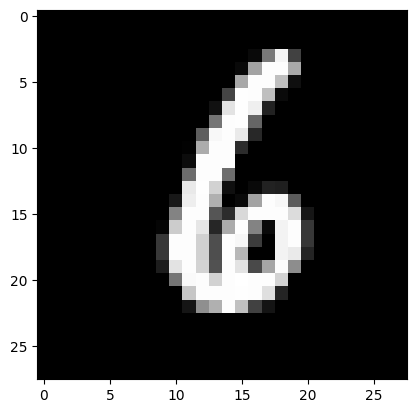

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

We'll also create a `device` which can be used to move the data and models to a GPU, if one is available.

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cpu')

## 2. Discriminator Network

The discriminator is a fully connected neural network model which classifies the input to a particular class. There are two classes here, fake and not fake. The cost function compares the expected output and the predicted label and further, the loss is computed, and then the parameters are updated. The discriminator model wants the cost function to be minimized.

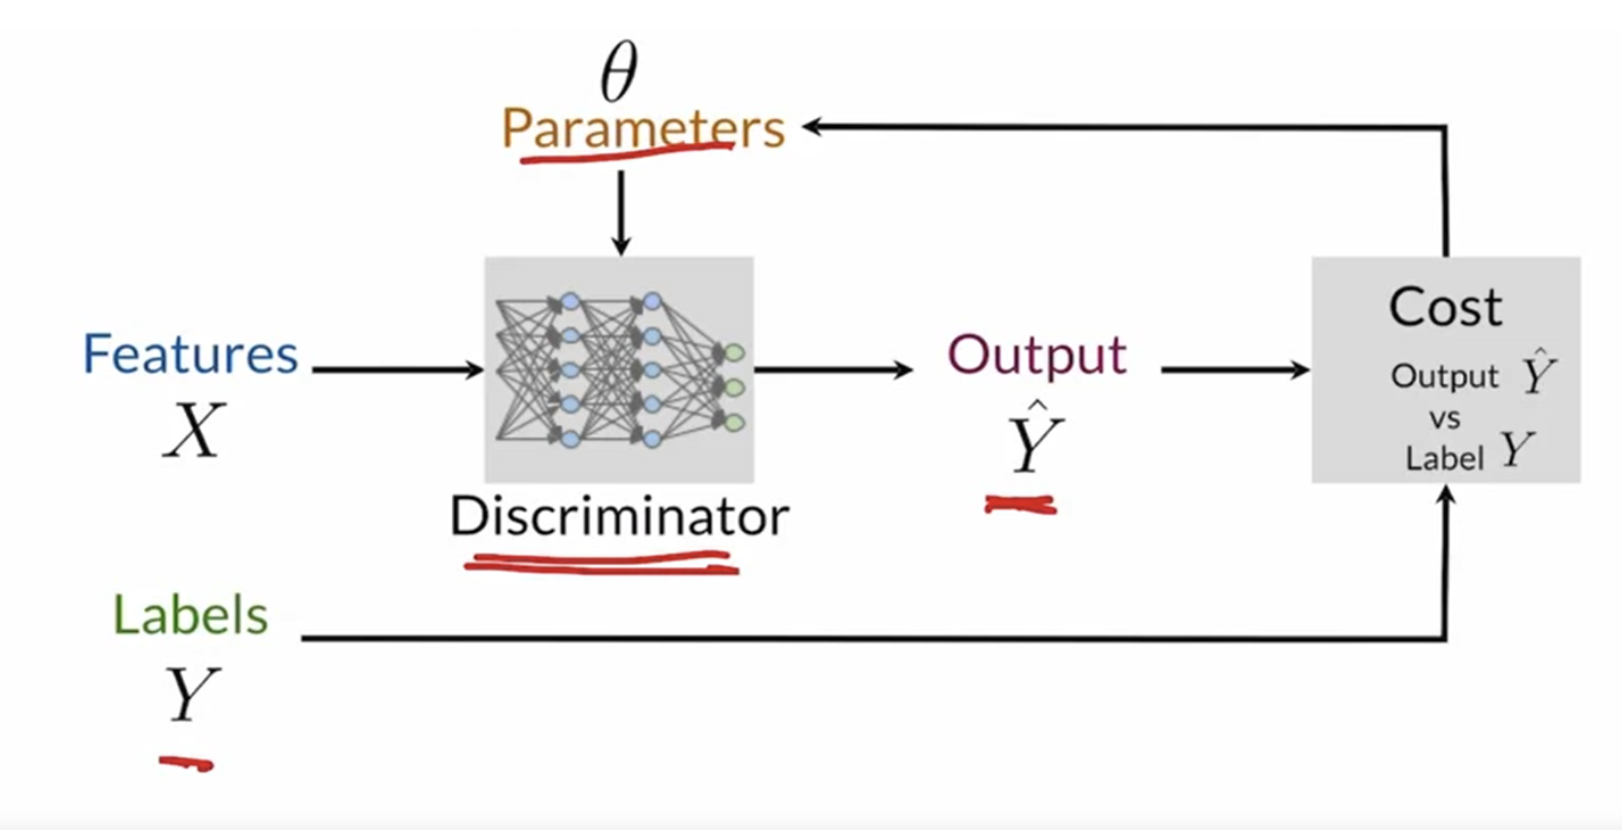

In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things simple. We'll treat each 28x28 image as a vector of size 784.

In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

We use the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.

Let's move the discriminator model to the chosen device.

In [11]:
D.to(device);

## 3. Generator Network


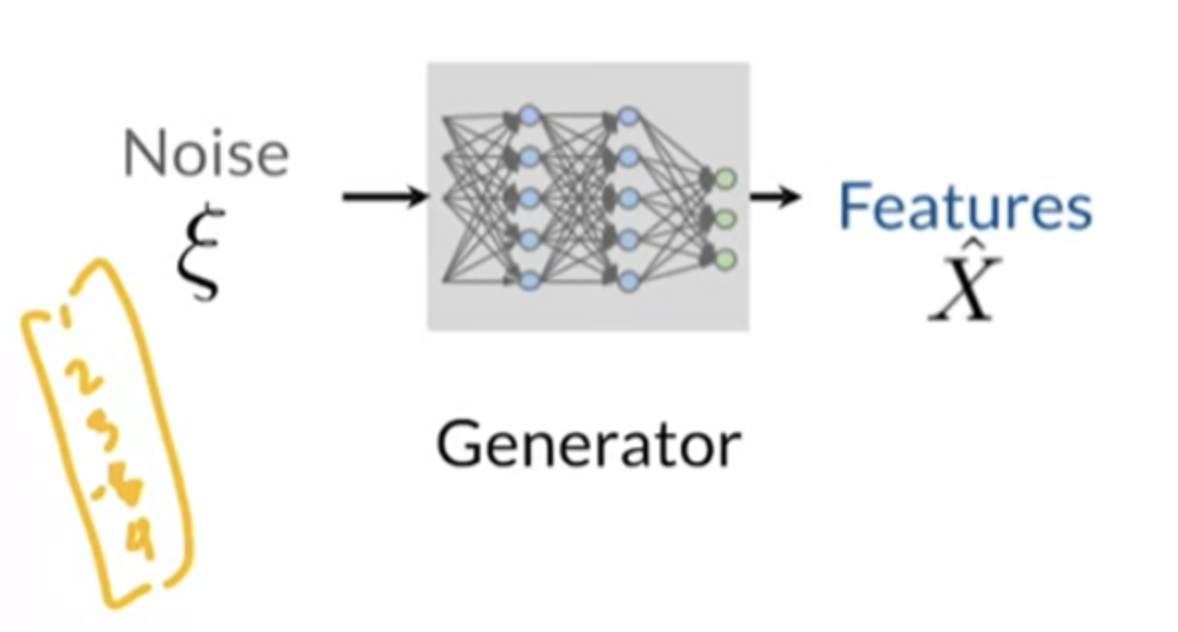

Generators work differently. They are fed with random noise and sometimes the class of the object that we want to generate. The model then outputs the features of the new individual belonging to the desired class. Now let’s check how the Generator learns.

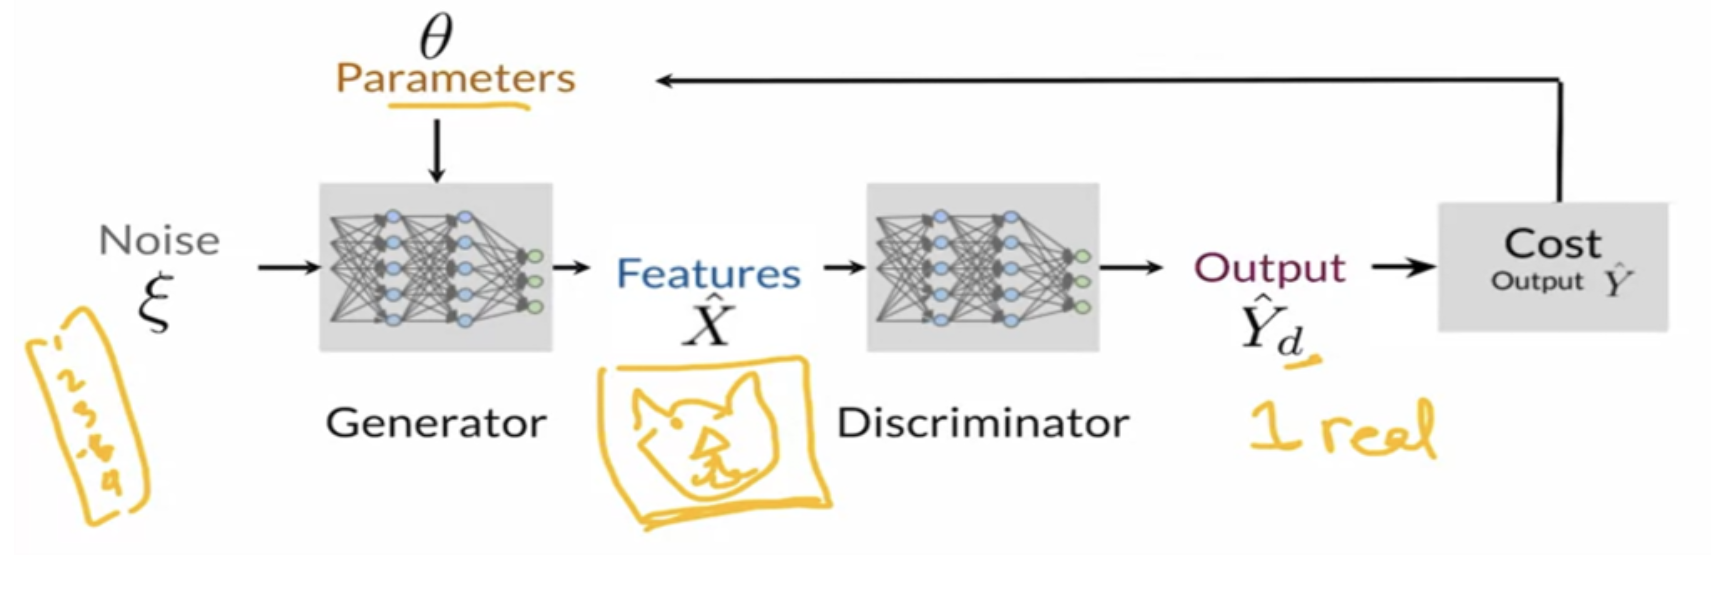

Here you can see that the features generated from the generator are fed to the discriminator and as explained before, it classifies the input as either fake or not fake. Then the generator loss is computed and further, the parameters are updated. The generator keeps feedback from the discriminator. Keep in mind that the generator wants to maximize the cost function. It wants to create maximum confusion for the discriminator. The discriminator wants to minimize the cost function. This is kind of like a min-max competition where one competes to outperform the other.

Well, this goes on until the generator is well learned and at a particular stage, the generator outperforms the discriminator. At that point, we will freeze the parameters of the generator and use them to create samples of the desired class.

Since this is a Vanilla GAN we are using below combinations:

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

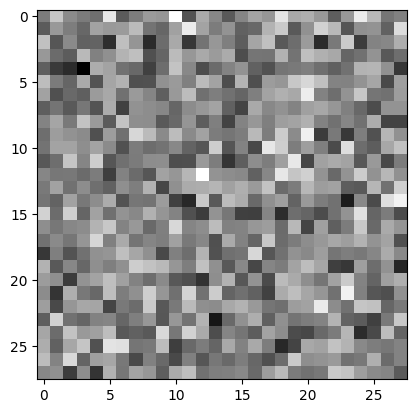

In [15]:
plt.imshow(gen_imgs[0], cmap='gray');

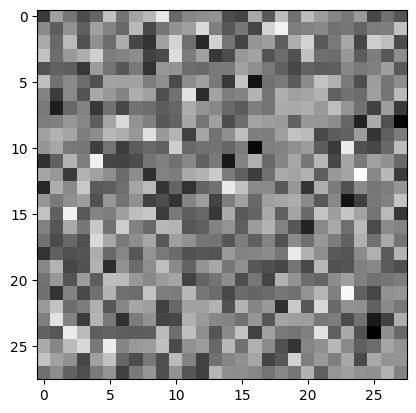

In [16]:
plt.imshow(gen_imgs[1], cmap='gray');

As one might expect, the output from the generator is basically random noise. Let's define a helper function which can save a batch of outputs from the generator to a file.

Let's move the generator to the chosen device.

In [17]:
G.to(device);

## 4. Minmax Game by Generator & Discriminator

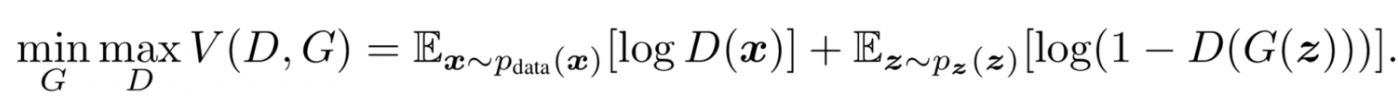

Above is the loss function of GAN. The loss/error function used maximizes the function D(x), and it also minimizes D(G(z)) where x is the real image, and G(z) is the generated image.

Let’s look above loss function from Generator perspective: since x is the actual image, we want D(x) be 1, and Generator tries to increase the value of D(G(z)) i.e. probability of being real. The training procedure for G is to maximize the probability of D making a mistake by generating data as realistic as possible.

Let’s look above loss function from Discriminator perspective: since x is the actual image, we want D(x) be 1, and Discriminator tries to decrease the value of D(G(z)) as 0 i.e fake image.

After training, the Generator and Discriminator will reach a point at which both cannot improve anymore. This is the state where the Generator produces more realistic images and Discriminator can’t distinguish it as fake.



## 5. Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.


<div class="alert alert-block alert-info">
<b>Tip:</b> We know that while training a GAN, we need to train two neural networks simultaneously. One is the discriminator and the other is the generator. To get the desired and effective results, the sequence in this training procedure is very important.
</div>

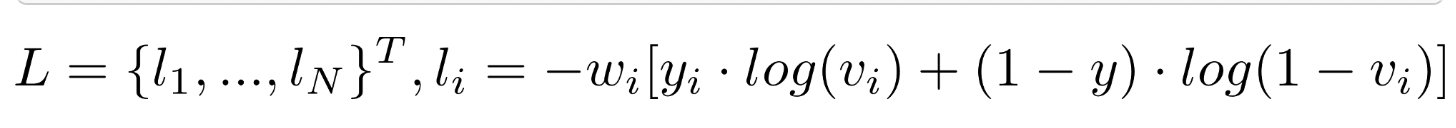

Above is the Binary Cross Entropy Loss (BCE Loss) function where y are named targets, v are the inputs, and w are the weights

1. First, we get the real data and the real labels (real labels are all 1s). The length of the real label should be equal to the batch size.
2. Then we do a forward pass by feeding the real data to the discriminator neural network.This gives us the real outputs from the real data.
3. Calculate the discriminator loss for the real outputs and labels and backpropagate it.
4. Get the fake data using the noise vector and do a forward pass through the generator. Get fake labels as well.
5. Using the fake data, do a forward pass through the discriminator.Calculate the loss using the fake data outputs and the fake labels. Backpropagate the fake data loss. Then calculate the total discriminator loss by adding real data loss and fake data loss.
6. Update the discriminator optimizer parameters.

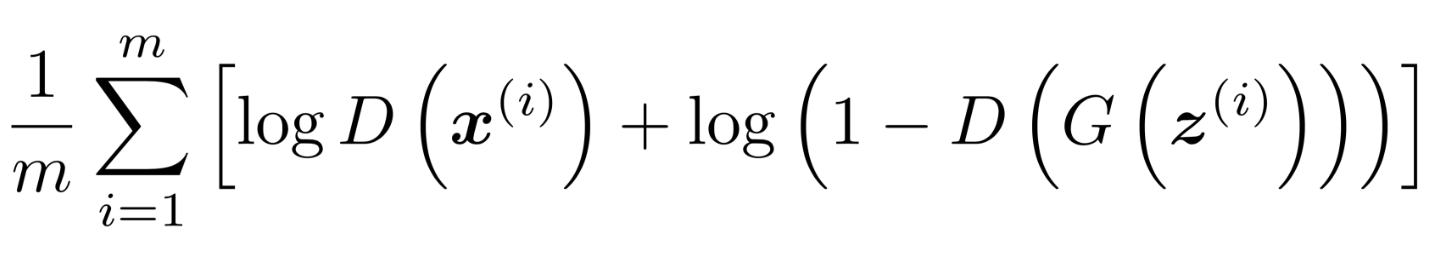

If we replace vᵢ = D(xᵢ) and yᵢ=1 ∀ i (for all i) in the BCE-Loss definition, we obtain the loss related to the real-images. Conversely, if we set vᵢ = D(G(zᵢ)) and yᵢ=0 ∀ i, we obtain the loss related to the fake-images. By summing up these two discriminator losses we obtain the total mini-batch loss for the Discriminator.

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

Let's define helper functions to reset gradients and  train the discriminator.

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated.Â 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.Â 

- Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.Â 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`d_optimizer` only affects the `D.parameters()`)

## 6. Generator Training

1. For the generator training, first, get the fake data by doing a forward pass through the generator. Get the real labels (all 1s).
2. Then do a forward pass through the discriminator using the fake data and the labels.
3. Calculate the loss and backpropagate them.
4. But this time, update the generator optimizer parameters.

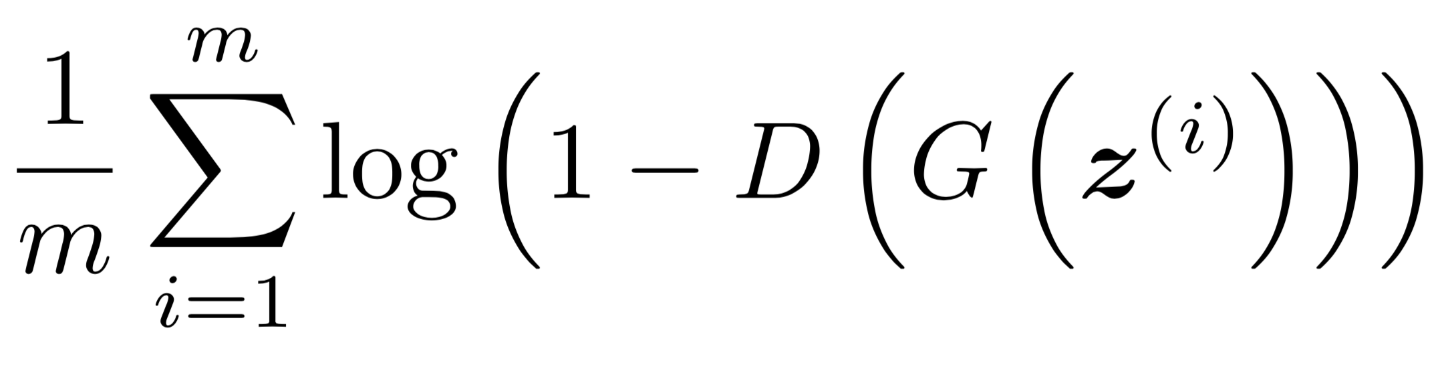

Rather than minimizing log(1- D(G(z))), training the Generator to maximize log D(G(z)) will provide much stronger gradients early in training. Similar to the Discriminator, if we set vᵢ = D(G(zᵢ)) and yᵢ=1 ∀ i, we obtain the desired loss to be minimized.

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.Â 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

## 7. Training the Model

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

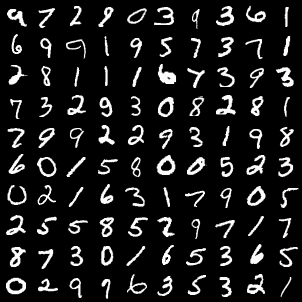

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


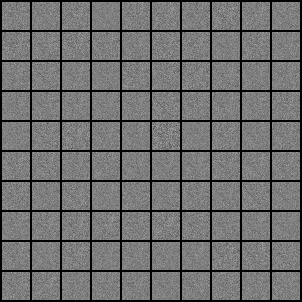

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

<div class="alert alert-block alert-success">
<b>Yayyy: We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while since we are not using a GPU.
</div>

In [25]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0386, g_loss: 4.2642, D(x): 1.00, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.0846, g_loss: 5.7689, D(x): 0.97, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0413, g_loss: 4.7808, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0780, g_loss: 4.1509, D(x): 0.97, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.3059, g_loss: 3.5557, D(x): 0.91, D(G(z)): 0.11
Epoch [1/300], Step [600/600], d_loss: 0.0660, g_loss: 4.5258, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.7184, g_loss: 3.2315, D(x): 0.88, D(G(z)): 0.37
Epoch [2/300], Step [400/600], d_loss: 0.5386, g_loss: 3.5424, D(x): 0.87, D(G(z)): 0.24
Epoch [2/300], Step [600/600], d_loss: 0.2022, g_loss: 4.5588, D(x): 0.92, D(G(z)): 0.08
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.6253, g_loss: 2.8355, D(x): 0.82, D(G(z)): 0.16
Epoch [3/300], Step [400/6

Now that we have trained the models, we can save checkpoints.

In [29]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Let's check the generated images, after the training.

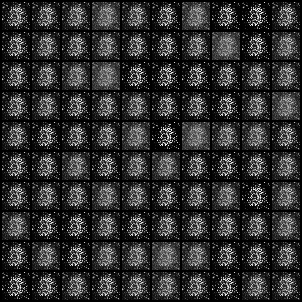

In [33]:
Image('./samples/fake_images-0001.png')

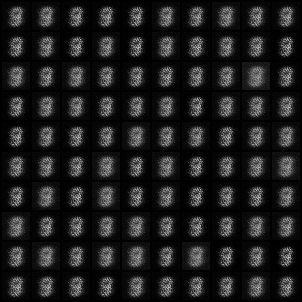

In [34]:
Image('./samples/fake_images-0005.png')

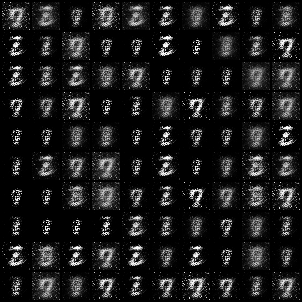

In [35]:
Image('./samples/fake_images-0010.png')

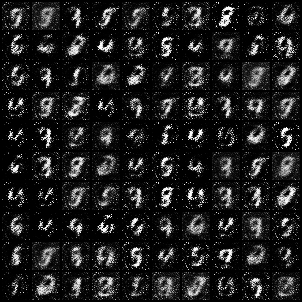

In [36]:
Image('./samples/fake_images-0025.png')

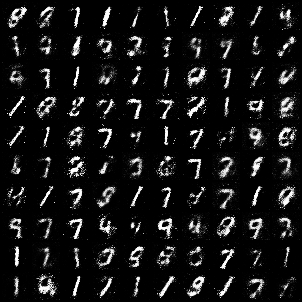

In [37]:
Image('./samples/fake_images-0050.png')

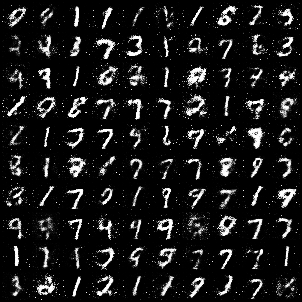

In [38]:
Image('./samples/fake_images-0080.png')

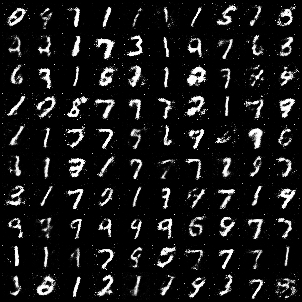

In [39]:
Image('./samples/fake_images-0100.png')

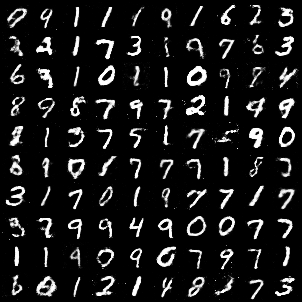

In [40]:
Image('./samples/fake_images-0300.png')

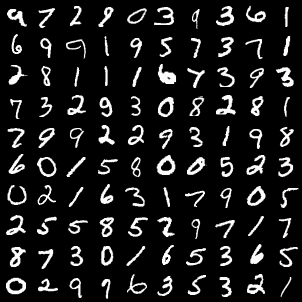

In [43]:
Image(os.path.join(sample_dir, 'real_images.png'))

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [48]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/Users/A117870943/Documents/T-Systems/POC/GAN/gans_training.avi

We can also visualize how the loss changes over time. Visualizing losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.

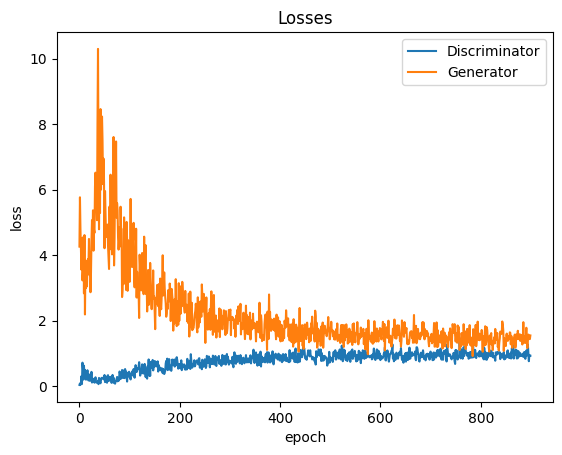

In [52]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

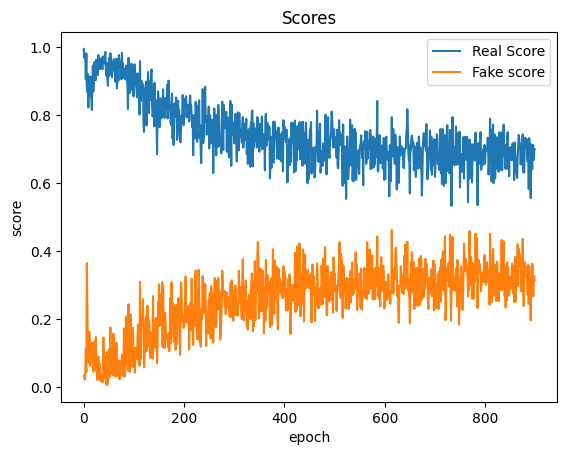

In [53]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## 8. Results

To conclude, we train Discriminator network using unsupervised learning so we don’t need any labels. We calculate the loss on real data and label it as 1. Next, we will calculate the loss on fake data(noise) coming from the generator network. Finally, we train Generator network by passing noise to it, and the result of output is then passed to discriminator to predict real or fake image. And after calculating the loss we back-propagate the generator network
